In [ ]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import spacy

import re
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
## Functions
_patterns = [r"\'", r"\"", r"\.", r"<br \/>", r",", r"\(", r"\)", r"\!", r"\?", r"\;", r"\:", r"\s+"]

_replacements = [" '  ", "", " . ", " ", " , ", " ( ", " ) ", " ! ", " ? ", " ", " ", " "]

_patterns_dict = list((re.compile(p), r) for p, r in zip(_patterns, _replacements))

def _basic_english_normalize(line):
    r"""
    Basic normalization for a line of text.
    Normalization includes
    - lowercasing
    - complete some basic text normalization for English words as follows:
        add spaces before and after '\''
        remove '\"',
        add spaces before and after '.'
        replace '<br \/>'with single space
        add spaces before and after ','
        add spaces before and after '('
        add spaces before and after ')'
        add spaces before and after '!'
        add spaces before and after '?'
        replace ';' with single space
        replace ':' with single space
        replace multiple spaces with single space

    Returns a list of tokens after splitting on whitespace.
    """

    line = line.lower()
    for pattern_re, replaced_str in _patterns_dict:
        line = pattern_re.sub(replaced_str, line)
    return line.split()



def get_tokenizer(tokenizer, language='en'):
    r"""
    Generate tokenizer function for a string sentence.

    Arguments:
        tokenizer: the name of tokenizer function. If None, it returns split()
            function, which splits the string sentence by space.
            If basic_english, it returns _basic_english_normalize() function,
            which normalize the string first and split by space. If a callable
            function, it will return the function. If a tokenizer library
            (e.g. spacy, moses, toktok, revtok, subword), it returns the
            corresponding library.
        language: Default en

    Examples:
        >>> import torchtext
        >>> from torchtext.data import get_tokenizer
        >>> tokenizer = get_tokenizer("basic_english")
        >>> tokens = tokenizer("You can now install TorchText using pip!")
        >>> tokens
        >>> ['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']

    """

    # default tokenizer is string.split(), added as a module function for serialization


    if tokenizer == "basic_english":
        if language != 'en':
            raise ValueError("Basic normalization is only available for Enlish(en)")
        return _basic_english_normalize

    # simply return if a function is passed
    if callable(tokenizer):
        return tokenizer

    if tokenizer == "spacy":
        try:
            import spacy
            spacy = spacy.load(language)
            return partial(_spacy_tokenize, spacy=spacy)
        except ImportError:
            print("Please install SpaCy. "
                  "See the docs at https://spacy.io for more information.")
            raise
        except AttributeError:
            print("Please install SpaCy and the SpaCy {} tokenizer. "
                  "See the docs at https://spacy.io for more "
                  "information.".format(language))
            raise
    elif tokenizer == "moses":
        try:
            from sacremoses import MosesTokenizer
            moses_tokenizer = MosesTokenizer()
            return moses_tokenizer.tokenize
        except ImportError:
            print("Please install SacreMoses. "
                  "See the docs at https://github.com/alvations/sacremoses "
                  "for more information.")
            raise
    elif tokenizer == "toktok":
        try:
            from nltk.tokenize.toktok import ToktokTokenizer
            toktok = ToktokTokenizer()
            return toktok.tokenize
        except ImportError:
            print("Please install NLTK. "
                  "See the docs at https://nltk.org  for more information.")
            raise
    elif tokenizer == 'revtok':
        try:
            import revtok
            return revtok.tokenize
        except ImportError:
            print("Please install revtok.")
            raise
    elif tokenizer == 'subword':
        try:
            import revtok
            return partial(revtok.tokenize, decap=True)
        except ImportError:
            print("Please install revtok.")
            raise
    raise ValueError("Requested tokenizer {}, valid choices are a "
                     "callable that takes a single string as input, "
                     "\"revtok\" for the revtok reversible tokenizer, "
                     "\"subword\" for the revtok caps-aware tokenizer, "
                     "\"spacy\" for the SpaCy English tokenizer, or "
                     "\"moses\" for the NLTK port of the Moses tokenization "
                     "script.".format(tokenizer))

In [ ]:
# Load the dataset
url = 'https://raw.githubusercontent.com/pinchunc/NMA_DL_SentimentAnalysis/main/Hippocorpus_data/hippoCorpusV2.csv'
df = pd.read_csv(url)
df = df[['story', 'stressful']]
df.head()

,story,stressful
0,"Concerts are my most favorite thing, and my bo...",1.0
1,"The day started perfectly, with a great drive ...",1.0
2,It seems just like yesterday but today makes f...,1.0
3,"Five months ago, my niece and nephew were born...",2.0
4,About a month ago I went to burning man. I was...,4.0


In [ ]:
# Split the data into train and test
X = df['story'].values       # Text data (input)
y = df['stressful'].values   # Labels (target)

# Split data
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify helps preserve that imbalance proportionally in both the training and test sets.


In [ ]:
# Exploratory Data Analisys (EDA).
for s, l in zip(x_train_text[:5], y_train[:5]):
  print('{}: {}'.format(l, s))

1.0: I must tell you about the even I attended recently. As you know my daughter is now in Kindergarten. They were wrapping up their school year and they had been practicing for a presentation for months. I know what you are thinking, how good will a presentation from little kids be? I was shocked. It was great. They put on a presentation about the founding of our country. They had one child playing Alexander Hamilton and another playing Ben Franklin. They went through all of the major events and it was great. Even though it doesn't seem like they knew what they were talking about it was so funny. The most surprising event was when my child, dressed like George Washington, started break dancing. It was so funny, every one was rolling with laughter. It actually made me recall my own child hood. One of my favorite parts of grammar school was the month before Christmas break where we would plan our Christmas assembly. It was fun learning the songs and it was also fun skipping regular clas

In [ ]:
# List comprehension to tokenize every sentence in the text
tokenizer = get_tokenizer("basic_english")

x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

# Observe the result of the tokenization of the first story
print('Before Tokenize: ', x_train_text[0])
print('After Tokenize: ', tokenizer(x_train_text[0]))

  0%|          | 0/5483 [00:00<?, ?it/s]

  0%|          | 0/1371 [00:00<?, ?it/s]

Before Tokenize:  I must tell you about the even I attended recently. As you know my daughter is now in Kindergarten. They were wrapping up their school year and they had been practicing for a presentation for months. I know what you are thinking, how good will a presentation from little kids be? I was shocked. It was great. They put on a presentation about the founding of our country. They had one child playing Alexander Hamilton and another playing Ben Franklin. They went through all of the major events and it was great. Even though it doesn't seem like they knew what they were talking about it was so funny. The most surprising event was when my child, dressed like George Washington, started break dancing. It was so funny, every one was rolling with laughter. It actually made me recall my own child hood. One of my favorite parts of grammar school was the month before Christmas break where we would plan our Christmas assembly. It was fun learning the songs and it was also fun skipping

In [ ]:
# Count how many different words are present in our dataset
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 25145
['.', 'i', 'the', 'to', 'and', ',', 'a', 'was', 'my', 'of', 'it', 'that', 'we', 'in', "'", 'for', 'had', 'me', 'he', 'with', 'she', 'on', 'so', 'her', 'but', 'this', 't', 'have', 'at', 'is', 'as', 'be', 'were', 'about', 'time', 'all', 'not', 'up', 'out', 'they', 'our', 'when', 'him', 'there', 'would', 's', 'just', 'day', 'his', 'from', 'one', 'been', 'get', 'very', 'got', 'like', 'went', 'after', 'some', 'because', 'an', 'what', 'really', 'life', 'back', 'do', 'could', 'more', 'us', '!', 'family', 'go', 'how', 'will', 'going', 'them', 'am', 'can', 'see', 'did', 'you', 'much', 'months', 'are', 'even', 'first', 'ago', 'then', 'has', 'by', 'now', 'didn', 'home', 'or', 'over', 'know', 'other', 'made', 'also', 'into']


In [ ]:
# Plot the distribution of different tokens
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 1.7140584609266256% most common words account for the 80.01789193198839% of the occurrences


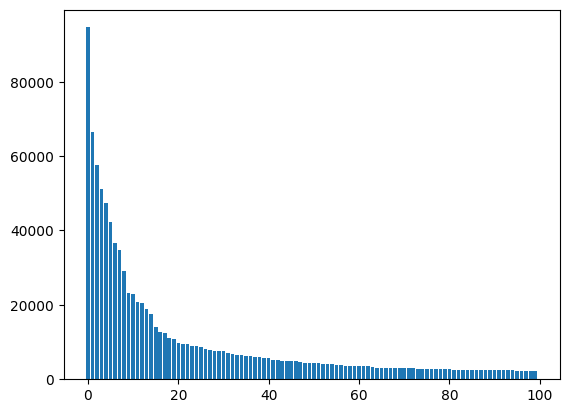

In [ ]:
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()